<a href="https://colab.research.google.com/github/quinnalfaro/OConnorFinalProject/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go

# Read in data
Because this is a Kaggle competition I made my df_val from splitting it off of the entire training dataframe.

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/FinalProjectData/training.csv')
df_train = df_train.dropna()
# For the purposes of testing out the model I've split the training dataset to make test and val
df_train, df_val = train_test_split(df_train, test_size=0.2)

# Modified Digits data Class for CNN

Here we change the data to be in the shape of 1x96x96 as it is a black and white image. We initialize the dataset and then ad the get item function to easily and quickly pull data from the dataset

In [147]:
class DigitsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        

        x = row['Image'].split()

        x = np.float32(np.array(x))
        # Changing shape is only mod needed for cnn, Change 1 to 3 for color
        x = np.reshape(x, (1, 96,96))

        # Turn into numpy array
        y = np.float32(row[:30].values)
        return x, y

## Creating instance of dataset and creating dataloader

In [148]:
dataset_train = DigitsDataset(df_train)
dataset_val = DigitsDataset(df_val)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 64, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 64, shuffle = True)

# Quick test
Here we have a quick test to make sure our dataloader is working and outputting the image as we want.

tensor([68.9044, 34.9297, 24.4227, 33.0039, 59.6617, 34.5445, 79.4954, 34.1594,
        35.9764, 34.1594, 14.9872, 31.6560, 58.8914, 26.0717, 87.3906, 24.1459,
        37.5170, 26.2641,  9.0178, 22.6057, 46.3750, 59.5773, 61.2019, 78.2559,
        29.0443, 75.7525, 45.2195, 74.5970, 44.8343, 83.6474])

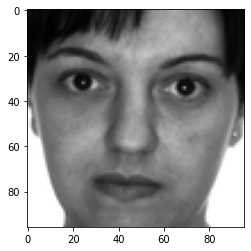

In [150]:
X_batch, Y_batch = next(iter(dataloader_train))
plt.imshow(X_batch[0][0],cmap='gray')
Y_batch[0]

## Simple Convelutional Neuralnet
Here we create the neural network object and add all of the necesary layers 

I found personally that having the first convelution be 1x32x3 gave the best results and lowest loss without overfitting. All of the following layers followed on suite. 

In [6]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        
        super().__init__()

        # Convelutional Layers
        self.conv1 = torch.nn.Conv2d(1,32,3)
        self.conv2 = torch.nn.Conv2d(32,64,3)
        # Dense Layer
        self.dense1 = torch.nn.Linear(30976,30)

        # Max Pool Layer
        self.pool = torch.nn.MaxPool2d(2)
        #Flattens conv2 into 1d array
        self.flatten = torch.nn.Flatten()
        self.ReLU = torch.nn.ReLU()
        
    def forward(self, x):

        #First Convelution 
        x = self.conv1(x)
        x = self.ReLU(x)
        x = self.pool(x)

        #Second Convelution 
        x = self.conv2(x)
        x = self.ReLU(x)
        x = self.pool(x)

        #Changes to 1D long array
        x = self.flatten(x)
        #Turns into correct size
        x = self.dense1(x)

        
        return x

# Create instance of the model

Because this is a regression style problem I chose a higher learning rate which I found gave much better results.

In [21]:
model = SimpleCNN()
device = torch.device('cuda')
model = model.to(device)

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# Train model

I then train the model and test the loss on the validation dataset. Because this is a regression style model, I used torch's Mean squared error functionality to measure the loss. After going through trial and error of different numbers of epochs (*as seen in the graphs below*) I landed on 5 epochs. 

In [22]:
num_epochs = 10
N_train = len(dataset_train)
N_val = len(dataset_val)

train_losses = []
val_losses = []

for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, Y_batch in dataloader_train:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        
        model.zero_grad()
        loss_oneBatch.backward()
        optimizer.step()
        
        train_loss += loss_oneBatch*N_batch
        
    model.eval()
    val_loss = 0.0
    for X_batch, Y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_oneBatch = loss_fun(outputs, Y_batch)
            val_loss += loss_oneBatch*N_batch
            
    train_losses.append(train_loss/N_train)
    val_losses.append(val_loss/N_val)
    
    print('epoch: ', ep, 'train loss: ', train_loss/N_train, 'validation loss: ', val_loss/N_val)

epoch:  0 train loss:  tensor(3.1975e+10, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(86.7408, device='cuda:0')
epoch:  1 train loss:  tensor(33.4479, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(16.7027, device='cuda:0')
epoch:  2 train loss:  tensor(11.6158, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.7808, device='cuda:0')
epoch:  3 train loss:  tensor(10.3866, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(11.0534, device='cuda:0')
epoch:  4 train loss:  tensor(10.4350, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.6560, device='cuda:0')
epoch:  5 train loss:  tensor(10.4723, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.6460, device='cuda:0')
epoch:  6 train loss:  tensor(10.2599, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.6835, device='cuda:0')
epoch:  7 train loss:  tensor(10.2841, device='cuda:0', grad_fn=<DivBackward0>) 

# Plotting the loss vs epoch

In the following plots we see that following the first epoch, which lead to a drop a drop in loss from 3.1975e+10 to 30, the training loss around 5 epochs tends to steady out. This also holds true for the validation loss. Because of this steep drop followed by a steading out, I decided to cap the number of epochs at 5. This would mean not only that there would be less to run and make the model less expensive, but also would avoid running the risk of overfitting that could come with having too many epochs. The following three graphs show first loss vs the number of epochs with a sort of zooming in on later epochs to show the true affect that they were having. One can see following the first big dropoff is graph one, that loss hovers between 10 and 12 for both.

### All 10 epochs and loss

Text(0.5, 1.0, 'Objective function value value versus epoch')

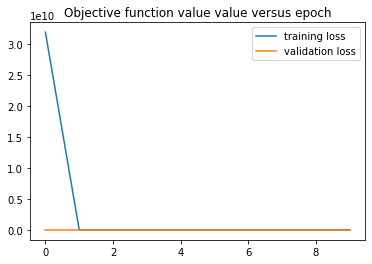

In [25]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

### Removing the first epoch

To see closer the loss in the following 9 epochs we remove the first and see an evening out

Text(0.5, 1.0, 'Objective function value value versus epoch')

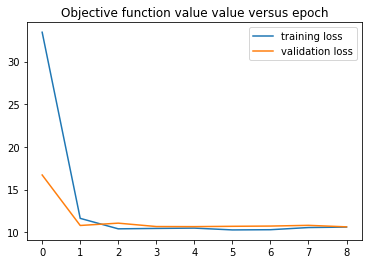

In [26]:
plt.plot(train_losses[1:], label = 'training loss')
plt.plot(val_losses[1:], label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

### Removing now the first two epochs

We see that following the fourth epoch the loss for both the trainging and the validation completely evens out and just bounces around between 10 and 11.

Text(0.5, 1.0, 'Objective function value value versus epoch')

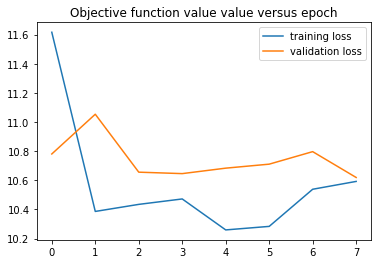

In [27]:
plt.plot(train_losses[2:], label = 'training loss')
plt.plot(val_losses[2:], label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

# PART #2 

## Using a pretrained resnet model 

We slightly change the dataset class and now add the **augment_data** boolean option when initializing the data, so if one would like to augment the data, they can in fact do so. 

In [3]:
class DigitsDatasetForRGB(torch.utils.data.Dataset):
    def __init__(self, df, augment_data = False):
        self.df = df
        self.augment_data = augment_data

        if augment_data:
          self.transform = A.Compose([
              A.GridDistortion(),
              A.Rotate(limit = 20, p = 0.5),
              A.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229,0.224,0.225))
          ])
        else:
          self.transform = A.Compose([A.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229,0.224,0.225))])

        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        

        x = row['Image'].split()

        x = np.float32(np.array(x))
        x = np.reshape(x, (96,96))
        # Changing shape is and stacking image is needed for rgb images in resnet
        ## Axis = 2 for data augmentation
        x = np.stack((x,x,x), axis=2)

        # Transform!
        x = self.transform(image = x)['image']

        #Change shape back
        x = np.transpose(x, (2,0,1))

        # Turn into numpy array
        y = np.float32(row[:30].values)
        # Updated torch.float to torch.long <--- MESSES UP RESNET
        #y = torch.tensor(y,dtype=torch.long)
        return x, y

In [4]:
dataset_train = DigitsDatasetForRGB(df_train)
dataset_val = DigitsDatasetForRGB(df_val)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 64, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 64, shuffle = True)

### Creating and modifying Resnet

Here we not only create the model but modify the final layer to have 30 outfeatures to match the 30 classes we are trying to predict through our regression style model.

In [5]:
#For resnet
model = torchvision.models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(in_features=512, out_features=30)

device = torch.device('cuda')
model = model.to(device)

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [7]:
num_epochs = 10
N_train = len(dataset_train)
N_val = len(dataset_val)

train_losses = []
val_losses = []

for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, Y_batch in dataloader_train:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        
        model.zero_grad()
        loss_oneBatch.backward()
        optimizer.step()
        
        train_loss += loss_oneBatch*N_batch
        
    model.eval()
    val_loss = 0.0
    for X_batch, Y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_oneBatch = loss_fun(outputs, Y_batch)
            val_loss += loss_oneBatch*N_batch
            
    train_losses.append(train_loss/N_train)
    val_losses.append(val_loss/N_val)
    
    print('epoch: ', ep, 'train loss: ', train_loss/N_train, 'validation loss: ', val_loss/N_val)

epoch:  0 train loss:  tensor(1931.5220, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(900.5385, device='cuda:0')
epoch:  1 train loss:  tensor(805.5688, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(343.1469, device='cuda:0')
epoch:  2 train loss:  tensor(275.8622, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(116.2086, device='cuda:0')
epoch:  3 train loss:  tensor(80.2554, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(33.3698, device='cuda:0')
epoch:  4 train loss:  tensor(22.8968, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(15.1034, device='cuda:0')
epoch:  5 train loss:  tensor(10.6487, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(9.6296, device='cuda:0')
epoch:  6 train loss:  tensor(8.6542, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.1937, device='cuda:0')
epoch:  7 train loss:  tensor(8.2832, device='cuda:0', grad_fn=<DivBackward0>)

Text(0.5, 1.0, 'Objective function value value versus epoch')

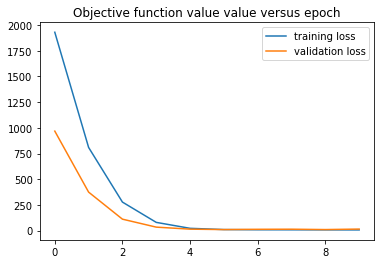

In [155]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

Text(0.5, 1.0, 'Objective function value value versus epoch')

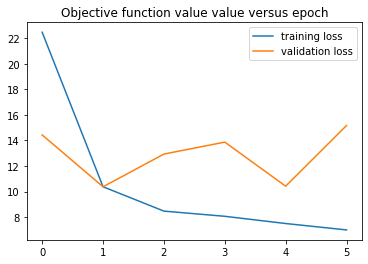

In [156]:
plt.plot(train_losses[4:], label = 'training loss')
plt.plot(val_losses[4:], label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

# Part #3 Data Augmentation!

Here we use the data augmentation functionality that we previously built to 

In [157]:
dataset_train = DigitsDatasetForRGB(df_train, True)
dataset_val = DigitsDatasetForRGB(df_val, True)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 64, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 64, shuffle = True)

In [158]:
#For resnet
model = torchvision.models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(in_features=512, out_features=30)

device = torch.device('cuda')
model = model.to(device)

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [159]:
num_epochs = 10
N_train = len(dataset_train)
N_val = len(dataset_val)

train_losses = []
val_losses = []

for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, Y_batch in dataloader_train:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        
        model.zero_grad()
        loss_oneBatch.backward()
        optimizer.step()
        
        train_loss += loss_oneBatch*N_batch
        
    model.eval()
    val_loss = 0.0
    for X_batch, Y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_oneBatch = loss_fun(outputs, Y_batch)
            val_loss += loss_oneBatch*N_batch
            
    train_losses.append(train_loss/N_train)
    val_losses.append(val_loss/N_val)
    
    print('epoch: ', ep, 'train loss: ', train_loss/N_train, 'validation loss: ', val_loss/N_val)

epoch:  0 train loss:  tensor(1927.2825, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(864.2728, device='cuda:0')
epoch:  1 train loss:  tensor(797.3791, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(355.3613, device='cuda:0')
epoch:  2 train loss:  tensor(269.1956, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(112.1131, device='cuda:0')
epoch:  3 train loss:  tensor(77.2030, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(40.8348, device='cuda:0')
epoch:  4 train loss:  tensor(22.2597, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(16.3067, device='cuda:0')
epoch:  5 train loss:  tensor(10.8129, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(11.4284, device='cuda:0')
epoch:  6 train loss:  tensor(9.0806, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(14.8949, device='cuda:0')
epoch:  7 train loss:  tensor(8.7751, device='cuda:0', grad_fn=<DivBackward0>

Text(0.5, 1.0, 'Objective function value value versus epoch')

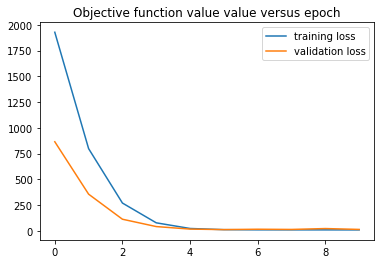

In [160]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')

plt.legend(loc = 'upper right')
plt.title('Objective function value value versus epoch')

# PART #4: Tying it all together


## Architectures and Structures of Models

Now that the models have been built built, loss over epochs has been graphed, architectures have been fiddled with, and multiple different learning rates have been tested for all three of our models, the following architectures and stats are what I believe give the best output for each of the three models

  ### 1. Simple Convelutional Neural Network:


  a. Architecture: 


    Depth = 1
    Convelutional Nodes = 32
    Size of Filter = 3x3
    Dense Layer = 30976 inputs, 30 outputs

  b. Training the model:

    The logic for the following choices can be seen and is explained in the graphs which show objective function value vs epochs.  

    epochs = 5
    learning rate = 0.1



   
 

### 2. Convelutional Neural Network Trained on RESNET:

  a. Architecture: 
    
    
    Depth = 1
    Convelutional nodes = 32
    size of filter = 3x3
    Dense Layer = 30976 inputs, 30 outputs

  b. Training the model:

    The logic for the following choices can be seen and is explained in the graphs which show objective function value vs epochs.  

    epochs = 5
    learning rate = 0.001



### 3. Convelutional Neural Network with Augmented Data Trained on resnet:

  a. Architecture: 
    
    
    Depth = 1
    Convelutional nodes = 64
    size of filter = 7x7
    Dense Layer = 512 inputs, 30 outputs


  b. Training the model:

    The logic for the following choices can be seen and is explained in the graphs which show objective function value vs epochs.  

    epochs = 7
    learning rate = 0.001





  

# Results

### 1. Simple Convelutional Neural Network:


  Loss: 

    Training set Loss:
        1st epoch: 3.1975e+10
        Final epoch: 10.4723

    Validation Set loss: 
        1st epoch: 86.7408
        Final epoch: 10.6460




   
 

### 2. Convelutional Neural Network Trained on RESNET:

  Loss: 

    Training set Loss:
        1st epoch: 1812.8149
        Final epoch: 19.6327

    Validation Set loss:
        1st epoch: 789.5609
        Final epoch: 11.6147




### 3. Convelutional Neural Network with Augmented Data Trained on resnet:


  Loss: 

    Training set Loss:
        1st epoch: 1808.2867
        Final epoch: 8.7980

    Validation Set loss: 
        1st epoch: 913.7388
        Final epoch: 9.9740


# Kaggle entry and predictions

## Retrain model

For this I am going to retrain the data augmentation model will the previously decided epochs we observed in the graph of epochs vs loss.

In [8]:
#For resnet
model = torchvision.models.resnet18(pretrained = True)
model.fc = torch.nn.Linear(in_features=512, out_features=30)

device = torch.device('cuda')
model = model.to(device)

loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

dataset_train = DigitsDatasetForRGB(df_train, True)
dataset_val = DigitsDatasetForRGB(df_val, True)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 64, shuffle = True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size = 64, shuffle = True)

In [9]:
num_epochs = 7
N_train = len(dataset_train)
N_val = len(dataset_val)

train_losses = []
val_losses = []

for ep in range(num_epochs):

    model.train()
    train_loss = 0.0
    batch_idx = 0
    
    for X_batch, Y_batch in dataloader_train:
        
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        N_batch = X_batch.shape[0]
        outputs = model(X_batch)
        loss_oneBatch = loss_fun(outputs, Y_batch)
        
        model.zero_grad()
        loss_oneBatch.backward()
        optimizer.step()
        
        train_loss += loss_oneBatch*N_batch
        
    model.eval()
    val_loss = 0.0
    for X_batch, Y_batch in dataloader_val:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        with torch.no_grad():
            
            N_batch = X_batch.shape[0]
            outputs = model(X_batch)
            loss_oneBatch = loss_fun(outputs, Y_batch)
            val_loss += loss_oneBatch*N_batch
            
    train_losses.append(train_loss/N_train)
    val_losses.append(val_loss/N_val)
    
    print('epoch: ', ep, 'train loss: ', train_loss/N_train, 'validation loss: ', val_loss/N_val)

epoch:  0 train loss:  tensor(1918.4764, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(686.6243, device='cuda:0')
epoch:  1 train loss:  tensor(791.3206, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(333.6642, device='cuda:0')
epoch:  2 train loss:  tensor(266.6734, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(102.6489, device='cuda:0')
epoch:  3 train loss:  tensor(76.0332, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(40.6730, device='cuda:0')
epoch:  4 train loss:  tensor(21.9675, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(19.7030, device='cuda:0')
epoch:  5 train loss:  tensor(10.8772, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(10.5521, device='cuda:0')
epoch:  6 train loss:  tensor(9.1067, device='cuda:0', grad_fn=<DivBackward0>) validation loss:  tensor(9.6413, device='cuda:0')


### Shape data

Because the Kaggle data of course does not have the correct labels or answers, I created 30 dummy columns filled with 0's so that the data could be easily fed into the data class without difficult modifications to the data class itself.

In [10]:
KaggleData = pd.read_csv('/content/drive/MyDrive/FinalProjectData/test.csv')
df = KaggleData
df = df.reindex(columns=list('A')*30).fillna(0)
df['Image'] = KaggleData['Image']
df.shape

(1783, 31)

### Data object

We set shuffle to false as we need it in the correct order for the Kaggle submission and then feed it into our data augmentation class. We also set the batch size to be the size of the entire dataset so we can just toss the output into a dataframe then .csv for easy submission to Kaggle.


In [11]:
dataset_Kaggle = DigitsDatasetForRGB(df, True)
dataloader_Kaggle = torch.utils.data.DataLoader(dataset_Kaggle, batch_size = 1783, shuffle = False)


### Sanity check

Here we are printing out one of the images and can see the augmentation being done to the face

30

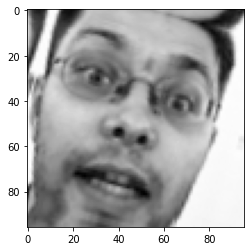

In [12]:
X_batch, Y_batch = next(iter(dataloader_Kaggle))
plt.imshow(X_batch[0][0],cmap='gray')
len(Y_batch[0])

In [13]:
X_batch = X_batch.to(device)
KaggleResults = model(X_batch)

In [14]:
df = pd.DataFrame(KaggleResults.tolist())
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,64.874290,36.058784,28.969097,36.296040,58.061974,37.037445,71.663887,36.788483,35.743389,37.100777,21.889536,37.253071,54.917404,28.586884,77.145485,28.909775,38.376682,28.790245,15.546316,29.788534,46.864555,55.978550,62.188931,73.962044,32.264141,74.208618,46.954121,71.055222,47.072575,79.840408
1,67.030243,37.252567,29.917543,37.502590,59.976055,38.266506,74.041756,38.020054,36.929611,38.338432,22.606909,38.496857,56.731003,29.545174,79.719162,29.879276,39.643154,29.761230,16.034594,30.783642,48.407856,57.868732,64.255562,76.458473,33.315044,76.715508,48.514198,73.483345,48.626862,82.530533
2,64.207787,35.692699,28.677876,35.919853,57.470177,36.651745,70.921867,36.401611,35.376595,36.724300,21.669243,36.862774,54.353794,28.294197,76.338692,28.609415,37.976547,28.493320,15.393057,29.476099,46.383163,55.391338,61.548157,73.186249,31.931574,73.433784,46.469120,70.306107,46.596180,78.999283
3,66.490540,36.948624,29.676941,37.199417,59.494053,37.961235,73.446182,37.712154,36.628857,38.024559,22.423227,38.185753,56.274982,29.302818,79.070724,29.635628,39.325344,29.511225,15.912539,30.537106,48.022644,57.394936,63.734280,75.830116,33.054939,76.084579,48.121067,72.876213,48.235756,81.853477
4,66.040359,36.704918,29.481310,36.945175,59.094696,37.701229,72.952629,37.452023,36.384701,37.769691,22.275028,37.925121,55.896839,29.102463,78.534790,29.433636,39.063927,29.314003,15.808623,30.325260,47.699085,56.998550,63.305618,75.311996,32.834114,75.566452,47.794632,72.369553,47.912251,81.293327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1778,66.734390,37.083088,29.784115,37.332840,59.712879,38.097134,73.712875,37.849400,36.760796,38.162430,22.501150,38.325382,56.478992,29.409908,79.358269,29.744709,39.466145,29.620079,15.973285,30.648642,48.197407,57.608089,63.964073,76.108833,33.177269,76.363678,48.300034,73.149040,48.407215,82.156723
1779,66.606346,37.021034,29.732122,37.266003,59.601414,38.027252,73.577911,37.780811,36.696560,38.095444,22.464869,38.255329,56.373867,29.357420,79.213600,29.686089,39.396473,29.570185,15.939408,30.587048,48.108276,57.497597,63.852264,75.970184,33.108696,76.227020,48.209141,73.010201,48.325470,82.002747
1780,67.763741,37.655071,30.237854,37.904770,60.624950,38.683334,74.851379,38.437916,37.328022,38.755264,22.841772,38.923553,57.346737,29.867451,80.588799,30.206375,40.072563,30.082697,16.203770,31.123556,48.934971,58.508583,64.951492,77.303375,33.682262,77.566544,49.038025,74.309334,49.147106,83.437347
1781,65.839966,36.591095,29.392673,36.835659,58.919010,37.588001,72.728729,37.337753,36.272854,37.652794,22.207682,37.808182,55.726910,29.015295,78.293686,29.341612,38.940895,29.220774,15.766809,30.235331,47.556046,56.822567,63.114235,75.077057,32.740505,75.328377,47.651955,72.142120,47.767990,81.038536


In [26]:
columns = pd.read_csv('/content/drive/MyDrive/FinalProjectData/training.csv').columns
columns = columns.drop('Image')
df.columns = columns

In [44]:
correctColumns = pd.read_csv('/content/drive/MyDrive/FinalProjectData/IdLookupTable.csv')

In [49]:
for i in range(len(correctColumns)):
  column = correctColumns.FeatureName.iloc[i]
  imgIDX = correctColumns.ImageId.iloc[i] - 1
  correctColumns.loc[i, 'Location'] = df[column][imgIDX]

In [50]:
correctColumns

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,64.874290
1,2,1,left_eye_center_y,36.058784
2,3,1,right_eye_center_x,28.969097
3,4,1,right_eye_center_y,36.296040
4,5,1,left_eye_inner_corner_x,58.061974
...,...,...,...,...
27119,27120,1783,right_eye_center_y,38.705864
27120,27121,1783,nose_tip_x,49.958935
27121,27122,1783,nose_tip_y,59.758820
27122,27123,1783,mouth_center_bottom_lip_x,50.167881


In [51]:
finalDF = correctColumns[['RowId', 'Location']]
finalDF.to_csv('/content/drive/MyDrive/FinalProjectData/kaggleSubmission.csv', index=False)

# Final submission!

With the data submitted to Kaggle I scored a score of 4.15 and got in the top 150!

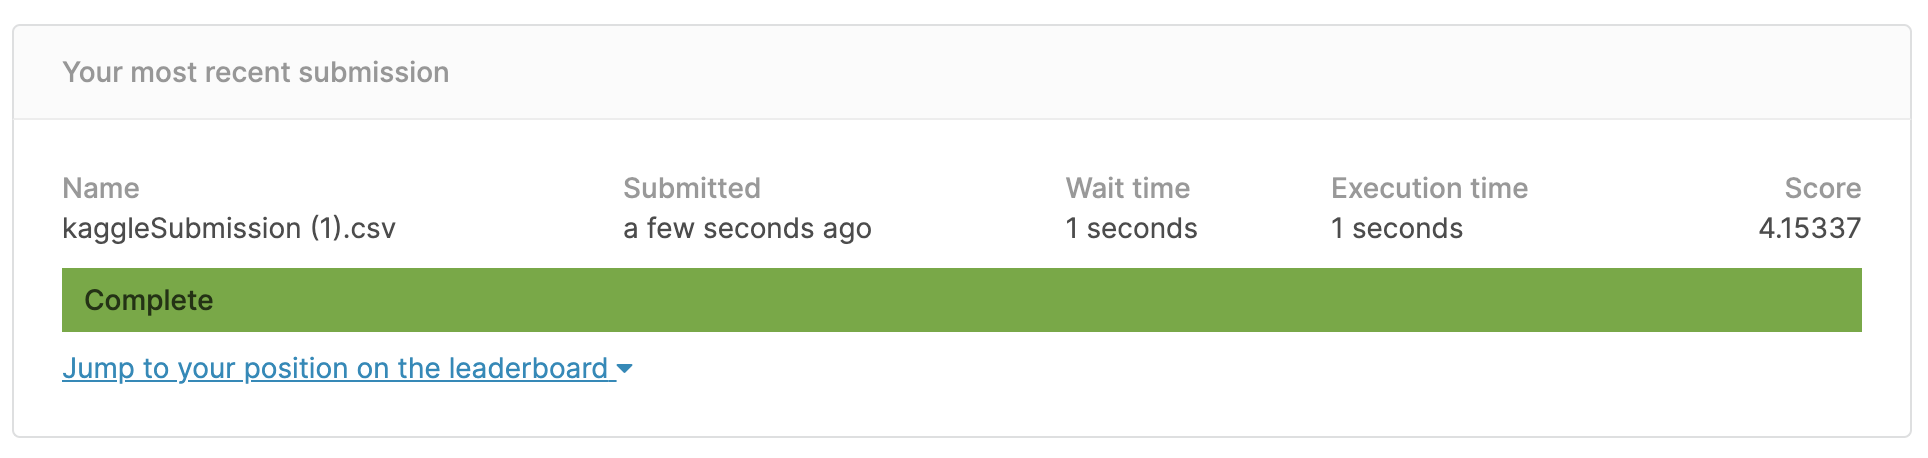